In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8k/Images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8k/Images/2949337912_beba55698b.jpg
/kaggle/input/flickr8k/Images/534886684_a6c9f40fa1.jpg
/kaggle/input/flickr8k/Images/3543600125_223747ef4c.jpg
/kaggle/input/flickr8k/Images/2174206711_11cb712a8d.jpg
/kaggle/input/flickr8k/Images/280706862_14c30d734a.jpg
/kaggle/input/flickr8k/Images/2100735137_05c6079537.jpg
/kaggle/input/f

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


In [3]:
# Paths
image_path = '../input/flickr8k/Images'
captions_file = '../input/flickr8k/captions.txt'

# Load captions
data = pd.read_csv(captions_file)

# Data preprocessing function
def text_preprocessing(data):
    data['caption'] = data['caption'].str.lower()
    data['caption'] = data['caption'].str.replace("[^a-zA-Z]", " ", regex=True)
    data['caption'] = data['caption'].str.replace("\s+", " ", regex=True)
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    data['caption'] = data['caption'].str.strip()
    return data

# Apply preprocessing
data = text_preprocessing(data)


In [4]:
images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85 * nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train_data = data[data['image'].isin(train_images)].reset_index(drop=True)
val_data = data[data['image'].isin(val_images)].reset_index(drop=True)


In [5]:
# Image transformations
img_size = 224
image_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [6]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
class ImageTextDataset(Dataset):
    def __init__(self, df, image_dir, transform, tokenizer, max_length=32):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image and caption
        image_name = self.df.loc[idx, 'image']
        caption = self.df.loc[idx, 'caption']

        # Load and transform image
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Tokenize caption
        text_inputs = self.tokenizer(
            caption,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Squeeze to remove extra dimension
        text_inputs = {key: val.squeeze(0) for key, val in text_inputs.items()}

        return image, text_inputs


In [8]:
batch_size = 32

train_dataset = ImageTextDataset(train_data, image_path, image_transforms, tokenizer)
val_dataset = ImageTextDataset(val_data, image_path, image_transforms, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [9]:
class CLIPModel(nn.Module):
    def __init__(self, embed_dim):
        super(CLIPModel, self).__init__()
        # Image Encoder: DenseNet201 without the classifier
        self.image_encoder = models.densenet201(pretrained=True)
        self.image_encoder.classifier = nn.Identity()
        self.image_projection = nn.Linear(1920, embed_dim)  # 1920 is the output feature size of DenseNet201

        # Text Encoder: BERT
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.text_projection = nn.Linear(self.text_encoder.config.hidden_size, embed_dim)

    def forward(self, image, input_ids, attention_mask):
        # Encode image
        image_features = self.image_encoder(image)
        image_embeddings = self.image_projection(image_features)
        image_embeddings = image_embeddings / image_embeddings.norm(p=2, dim=-1, keepdim=True)

        # Encode text
        text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]  # [CLS] token
        text_embeddings = self.text_projection(text_features)
        text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=-1, keepdim=True)

        return image_embeddings, text_embeddings


In [10]:
embed_dim = 256  # Dimension of the projected embeddings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CLIPModel(embed_dim)
model = model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 145MB/s] 


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [11]:
def contrastive_loss(image_embeddings, text_embeddings, temperature=0.05):
    # Normalize embeddings
    image_embeddings = image_embeddings / image_embeddings.norm(dim=1, keepdim=True)
    text_embeddings = text_embeddings / text_embeddings.norm(dim=1, keepdim=True)

    # Compute logits
    logits_per_image = torch.matmul(image_embeddings, text_embeddings.t()) / temperature
    logits_per_text = logits_per_image.t()

    # Labels
    batch_size = image_embeddings.size(0)
    labels = torch.arange(batch_size).to(device)

    # Losses
    loss_i = nn.CrossEntropyLoss()(logits_per_image, labels)
    loss_t = nn.CrossEntropyLoss()(logits_per_text, labels)
    loss = (loss_i + loss_t) / 2

    return loss


In [12]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 5
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (images, text_inputs) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()

        # Move data to device
        images = images.to(device)
        input_ids = text_inputs['input_ids'].to(device)
        attention_mask = text_inputs['attention_mask'].to(device)

        # Forward pass
        image_embeddings, text_embeddings = model(images, input_ids, attention_mask)

        # Compute loss
        loss = contrastive_loss(image_embeddings, text_embeddings)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


100%|██████████| 1075/1075 [07:17<00:00,  2.46it/s]


Epoch [1/5], Loss: 0.8490


100%|██████████| 1075/1075 [07:16<00:00,  2.46it/s]


Epoch [2/5], Loss: 0.3043


100%|██████████| 1075/1075 [07:16<00:00,  2.46it/s]


Epoch [3/5], Loss: 0.2196


100%|██████████| 1075/1075 [07:16<00:00,  2.46it/s]


Epoch [4/5], Loss: 0.1832


100%|██████████| 1075/1075 [07:16<00:00,  2.46it/s]

Epoch [5/5], Loss: 0.1575


In [16]:
def get_image_embedding(model, image_path):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = image_transforms(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_feature = model.image_encoder(image)
        image_embedding = model.image_projection(image_feature)
        image_embedding = image_embedding / image_embedding.norm(p=2, dim=-1, keepdim=True)
    return image_embedding

def get_text_embedding(model, text):
    model.eval()
    text_inputs = tokenizer(
        text,
        max_length=32,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    input_ids = text_inputs['input_ids'].to(device)
    attention_mask = text_inputs['attention_mask'].to(device)
    with torch.no_grad():
        text_outputs = model.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_feature = text_outputs.last_hidden_state[:, 0, :]
        text_embedding = model.text_projection(text_feature)
        text_embedding = text_embedding / text_embedding.norm(p=2, dim=-1, keepdim=True)
    return text_embedding

# Example usage
image_path_example = os.path.join(image_path, val_data.iloc[0]['image'])
caption_example = val_data.iloc[0]['caption']

image_embedding = get_image_embedding(model, image_path_example)
text_embedding = get_text_embedding(model, caption_example)

# Compute similarity
similarity = torch.matmul(image_embedding, text_embedding.t()).item()
print(f"Similarity between image and caption: {similarity}")


Similarity between image and caption: 0.5641509294509888


In [17]:
# Save the entire model
torch.save(model, 'clip_model_full.pth')


In [19]:
class ImageTextDataset(Dataset):
    def __init__(self, df, image_dir, transform, tokenizer, max_length=32):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image name and caption
        image_name = self.df.loc[idx, 'image']
        caption = self.df.loc[idx, 'caption']

        # Get image path
        image_path = os.path.join(self.image_dir, image_name)
        # Load and transform image
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Tokenize caption
        text_inputs = self.tokenizer(
            caption,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        text_inputs = {key: val.squeeze(0) for key, val in text_inputs.items()}

        return image, text_inputs, image_path, caption


In [21]:
# Create datasets
train_dataset = ImageTextDataset(train_data, image_path, image_transforms, tokenizer)
val_dataset = ImageTextDataset(val_data, image_path, image_transforms, tokenizer)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [22]:
# Get a single batch
for batch in val_loader:
    images, text_inputs, image_paths, captions = batch
    print(f"Images shape: {images.shape}")
    print(f"Text inputs keys: {text_inputs.keys()}")
    print(f"Number of image paths: {len(image_paths)}")
    print(f"Number of captions: {len(captions)}")
    break


Images shape: torch.Size([32, 3, 224, 224])
Text inputs keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Number of image paths: 32
Number of captions: 32


100%|██████████| 95/95 [00:29<00:00,  3.27it/s]


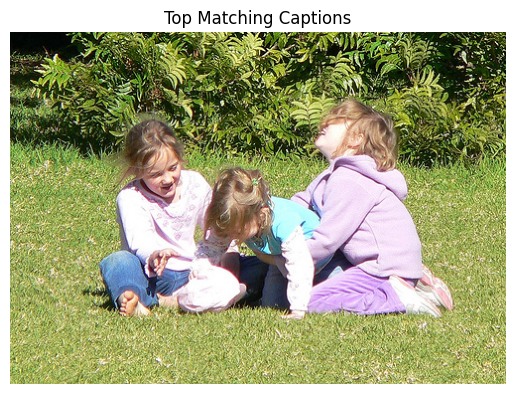

Caption 1: three little girls are sitting on the grass
Caption 2: three young girls are sitting on the lawn
Caption 3: woman is sitting on the grass and holding two children
Caption 4: woman is holding two children while sitting on the grass
Caption 5: woman holds two baby girls whilst sitting cross legged on the grass


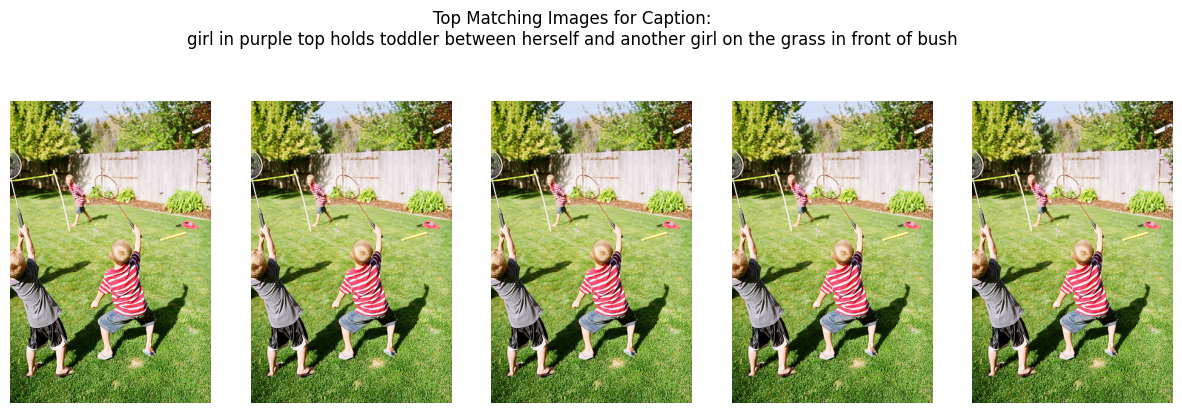

In [23]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader

# Adjusted DataLoader for evaluation
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

# Function to compute embeddings
def compute_embeddings(model, dataloader):
    model.eval()
    all_image_embeddings = []
    all_text_embeddings = []
    all_image_paths = []
    all_captions = []
    with torch.no_grad():
        for images, text_inputs, image_paths, captions in tqdm(dataloader):
            images = images.to(device)
            input_ids = text_inputs['input_ids'].to(device)
            attention_mask = text_inputs['attention_mask'].to(device)

            image_embeddings, text_embeddings = model(images, input_ids, attention_mask)

            all_image_embeddings.append(image_embeddings)
            all_text_embeddings.append(text_embeddings)
            all_image_paths.extend(image_paths)
            all_captions.extend(captions)

    all_image_embeddings = torch.cat(all_image_embeddings)
    all_text_embeddings = torch.cat(all_text_embeddings)
    return all_image_embeddings, all_text_embeddings, all_image_paths, all_captions

# Compute embeddings
all_image_embeddings, all_text_embeddings, all_image_paths, all_captions = compute_embeddings(model, val_loader)

# Normalize embeddings
all_image_embeddings_norm = all_image_embeddings / all_image_embeddings.norm(dim=1, keepdim=True)
all_text_embeddings_norm = all_text_embeddings / all_text_embeddings.norm(dim=1, keepdim=True)

# Compute similarity matrix
similarity_matrix = torch.matmul(all_image_embeddings_norm, all_text_embeddings_norm.t())

# Visualization functions
def display_image_with_captions(image_path, top_captions):
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.axis('off')
    plt.title('Top Matching Captions')
    plt.show()
    for i, caption in enumerate(top_captions):
        print(f"Caption {i+1}: {caption}")

def get_top_captions_for_image(image_idx, similarity_matrix, all_captions, top_k=5):
    similarity_scores = similarity_matrix[image_idx]
    top_indices = similarity_scores.argsort(descending=True)[:top_k]
    top_captions = [all_captions[idx] for idx in top_indices]
    return top_captions

def display_captions_with_images(caption, top_image_paths):
    fig, axes = plt.subplots(1, len(top_image_paths), figsize=(15, 5))
    for idx, image_path in enumerate(top_image_paths):
        image = Image.open(image_path).convert('RGB')
        axes[idx].imshow(image)
        axes[idx].axis('off')
    plt.suptitle(f"Top Matching Images for Caption:\n{caption}")
    plt.show()

def get_top_images_for_caption(caption_idx, similarity_matrix, all_image_paths, top_k=5):
    similarity_scores = similarity_matrix[:, caption_idx]
    top_indices = similarity_scores.argsort(descending=True)[:top_k]
    top_image_paths = [all_image_paths[idx] for idx in top_indices]
    return top_image_paths

# Example usage: Display top captions for an image
image_idx = 10  # Choose an image index
image_path = all_image_paths[image_idx]
top_captions = get_top_captions_for_image(image_idx, similarity_matrix, all_captions, top_k=5)
display_image_with_captions(image_path, top_captions)

# Example usage: Display top images for a caption
caption_idx = 10  # Choose a caption index
caption = all_captions[caption_idx]
top_image_paths = get_top_images_for_caption(caption_idx, similarity_matrix, all_image_paths, top_k=5)
display_captions_with_images(caption, top_image_paths)


In [24]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=bb781104ab5cd486e54cdb6d0134281266bbe10fa0c00c7bbbf18168c2876b97
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
from torchviz import make_dot

# Create a dummy input tensor for image and text
dummy_image = torch.randn(1, 3, 224, 224).to(device)  # A single RGB image of size 224x224
dummy_input_ids = torch.randint(0, 10000, (1, 32)).to(device)  # A dummy text input (tokenized) of max length 32
dummy_attention_mask = torch.ones((1, 32)).to(device)  # Dummy attention mask

# Forward pass through the model
image_embedding, text_embedding = model(dummy_image, dummy_input_ids, dummy_attention_mask)

# Create a visualization graph
graph = make_dot(image_embedding, params=dict(list(model.named_parameters())))

# Render the graph
graph.render("model_architecture", format="png")
